In [1]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 33.9 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 34.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.0 MB/s eta 0:00:00:00:01
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=731999 sha256=5d58147734cf89da886eb217baf51b085475506358585c5dbc3866094c8c3f7c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/74/47/c4/678b0a3d5213e2f8500f3ea0f8dc3c81478e5b806c557dff58
Successfully built pymeeus


In [29]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
import numpy as np
import os
import time
from prophet import Prophet
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from IPython.display import clear_output

In [30]:
region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
holidays_key = 'holidays_events.csv'
oil_key = 'oil.csv'

holiday = 's3://{}/{}/{}'.format(bucket, prefix, holidays_key)
oil = 's3://{}/{}/{}'.format(bucket, prefix, oil_key)

holidays = pd.read_csv(holiday)
oils = pd.read_csv(oil)


holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [31]:
df = pd.concat([oils, holidays])

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df['month'] = pd.DatetimeIndex(df.index).month
df['year'] = pd.DatetimeIndex(df.index).year
df['day'] = pd.DatetimeIndex(df.index).day

df

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,1
2013-01-02,93.14,NaN,NaN,NaN,NaN,NaN,1,2013,2
2013-01-03,92.97,NaN,NaN,NaN,NaN,NaN,1,2013,3
2013-01-04,93.12,NaN,NaN,NaN,NaN,NaN,1,2013,4
2013-01-07,93.20,NaN,NaN,NaN,NaN,NaN,1,2013,7
...,...,...,...,...,...,...,...,...,...
2017-12-22,NaN,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,NaN,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,NaN,Additional,National,Ecuador,Navidad-1,False,12,2017,24


In [32]:
oil_nans = df[df['dcoilwtico'].isna()]

oil_nans_by_month = df[df['dcoilwtico'].isna()]['month']
months_with_oil_nan = oil_nans_by_month.unique()

average_oil_by_month = []

for i in months_with_oil_nan:
    month_vals = df[df['month'] == i]
    total_oil = month_vals['dcoilwtico'].sum()
    average = round((total_oil/len(month_vals)), 2)
    average_oil_by_month.append((i, average))

for i in range(len(months_with_oil_nan)):
    df = df.copy()
    df.loc[(df['month'] == average_oil_by_month[i][0]) & (df['dcoilwtico'].isna()), 'dcoilwtico'] = average_oil_by_month[i][1]
    
df

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2013-01-01,54.32,NaN,NaN,NaN,NaN,NaN,1,2013,1
2013-01-02,93.14,NaN,NaN,NaN,NaN,NaN,1,2013,2
2013-01-03,92.97,NaN,NaN,NaN,NaN,NaN,1,2013,3
2013-01-04,93.12,NaN,NaN,NaN,NaN,NaN,1,2013,4
2013-01-07,93.20,NaN,NaN,NaN,NaN,NaN,1,2013,7
...,...,...,...,...,...,...,...,...,...
2017-12-22,32.70,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,32.70,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,32.70,Additional,National,Ecuador,Navidad-1,False,12,2017,24


,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2013-01-01,54.32,NaN,NaN,NaN,NaN,NaN,1,2013,1
2013-01-02,93.14,NaN,NaN,NaN,NaN,NaN,1,2013,2
2013-01-03,92.97,NaN,NaN,NaN,NaN,NaN,1,2013,3
2013-01-04,93.12,NaN,NaN,NaN,NaN,NaN,1,2013,4
2013-01-07,93.20,NaN,NaN,NaN,NaN,NaN,1,2013,7
...,...,...,...,...,...,...,...,...,...
2017-12-22,32.70,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,32.70,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,32.70,Additional,National,Ecuador,Navidad-1,False,12,2017,24


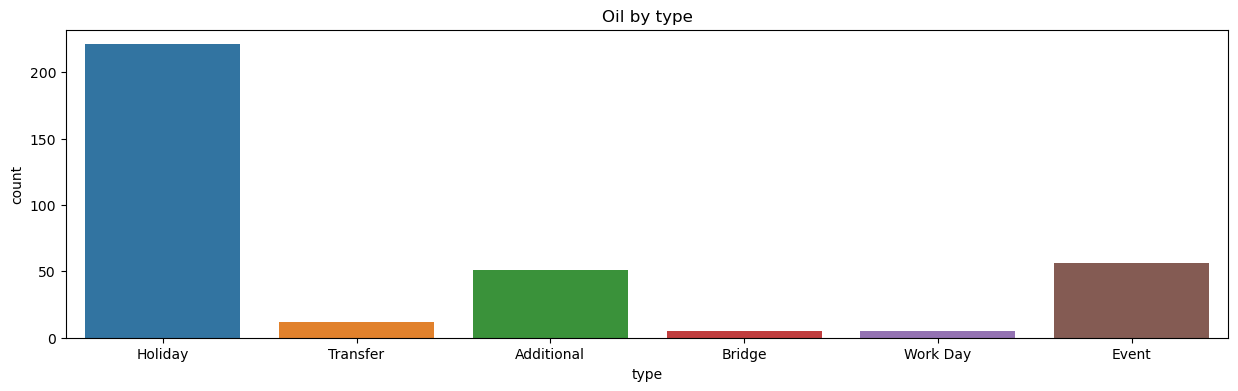

In [33]:
oil_by_month = df.groupby('type')['dcoilwtico'].count()

plt.figure(figsize=(15,4))
sns.countplot(data=df, x='type')
plt.title('Oil by type')
df

Text(0.5, 1.0, 'Oil by day')

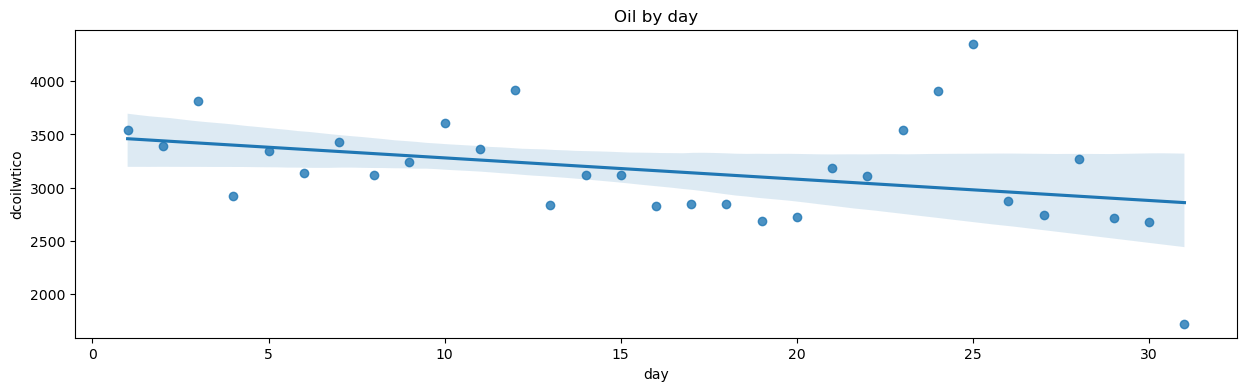

In [34]:
oil_by_day = df.groupby('day')['dcoilwtico'].sum()
plt.figure(figsize=(15,4))
sns.regplot(x=oil_by_day.index, y=oil_by_day)
plt.title('Oil by day')

Text(0.5, 1.0, 'Oil by day')

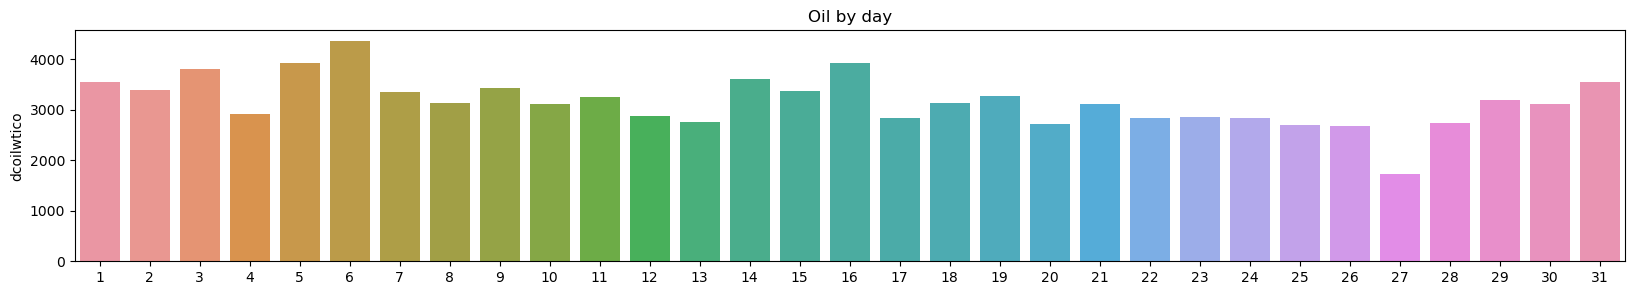

In [35]:
plt.figure(figsize=(20,3))
sns.barplot(x=df['day'].unique(), y=oil_by_day)
plt.title('Oil by day')

Text(0.5, 1.0, 'Oil by month')

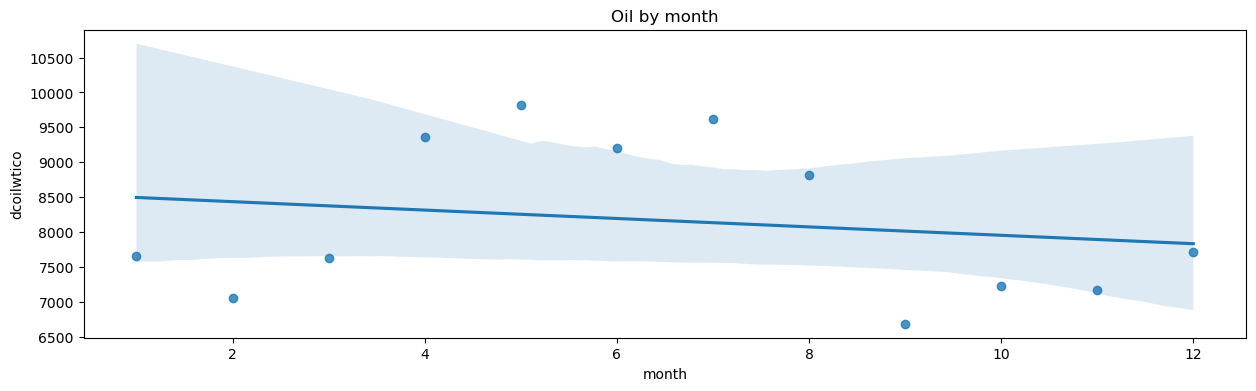

In [36]:
oil_by_month = df.groupby('month')['dcoilwtico'].sum()
plt.figure(figsize=(15,4))
sns.regplot(x=oil_by_month.index, y=oil_by_month)
plt.title('Oil by month')

Text(0.5, 1.0, 'Oil by month')

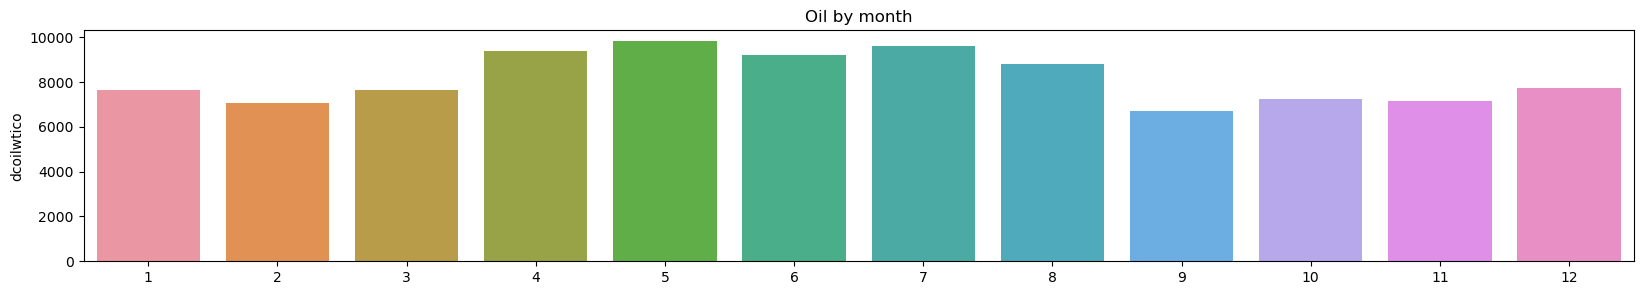

In [37]:
plt.figure(figsize=(20,3))
sns.barplot(x=df['month'].unique(), y=oil_by_month)
plt.title('Oil by month')

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2013-01-01,54.32,NaN,NaN,NaN,NaN,NaN,1,2013,1
2013-01-02,93.14,NaN,NaN,NaN,NaN,NaN,1,2013,2
2013-01-03,92.97,NaN,NaN,NaN,NaN,NaN,1,2013,3
2013-01-04,93.12,NaN,NaN,NaN,NaN,NaN,1,2013,4
2013-01-07,93.20,NaN,NaN,NaN,NaN,NaN,1,2013,7
...,...,...,...,...,...,...,...,...,...
2017-12-22,32.70,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,32.70,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,32.70,Additional,National,Ecuador,Navidad-1,False,12,2017,24


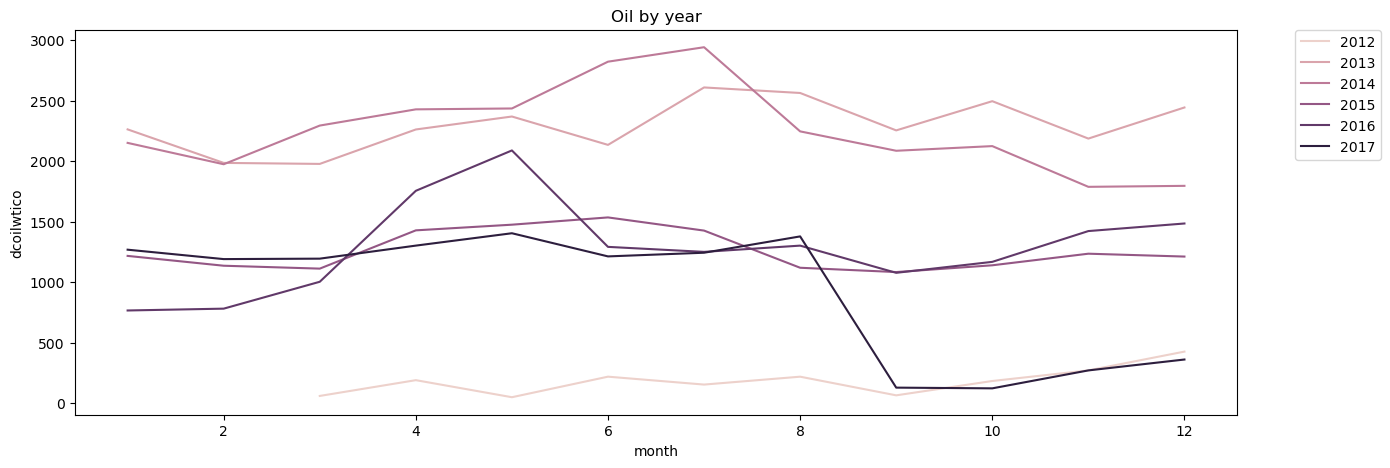

In [38]:
oil_per_year = df.groupby(['year','month'])['dcoilwtico'].sum()

oil_per_year = pd.DataFrame(oil_per_year)
oil_per_year = oil_per_year.reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(data=oil_per_year, x=oil_per_year['month'], y=oil_per_year['dcoilwtico'],hue=oil_per_year['year'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Oil by year')
df

Text(0.5, 1.0, 'Oil by day')

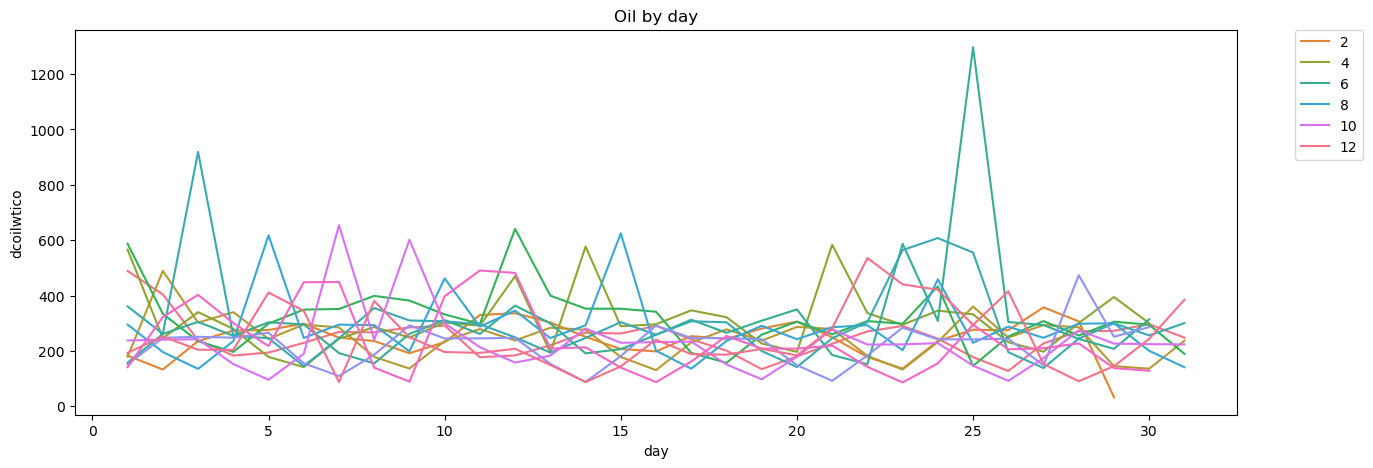

In [39]:
oil_per_day = df.groupby(['month','day'])['dcoilwtico'].sum()

oil_per_day = pd.DataFrame(oil_per_day)
oil_per_day = oil_per_day.reset_index()


plt.figure(figsize=(15,5))
sns.lineplot(data=oil_per_day, x=oil_per_day['day'], y=oil_per_day['dcoilwtico'],hue=oil_per_day['month'], palette='husl')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Oil by day')

In [40]:
types_mode = df['type'].value_counts().idxmax()
locale_mode = df['locale'].value_counts().idxmax()
locale_name_mode = df['locale_name'].value_counts().idxmax()
description_mode = df['description'].value_counts().idxmax()
transferred_mode = df['transferred'].value_counts().idxmax()

df.loc[df['type'].isna(), 'type'] = types_mode
df.loc[df['locale'].isna(), 'locale'] = locale_mode
df.loc[df['locale_name'].isna(), 'locale_name'] = locale_name_mode
df.loc[df['description'].isna(), 'description'] = description_mode
df.loc[df['transferred'].isna(), 'transferred'] = transferred_mode

df

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2013-01-01,54.32,Holiday,National,Ecuador,Carnaval,False,1,2013,1
2013-01-02,93.14,Holiday,National,Ecuador,Carnaval,False,1,2013,2
2013-01-03,92.97,Holiday,National,Ecuador,Carnaval,False,1,2013,3
2013-01-04,93.12,Holiday,National,Ecuador,Carnaval,False,1,2013,4
2013-01-07,93.20,Holiday,National,Ecuador,Carnaval,False,1,2013,7
...,...,...,...,...,...,...,...,...,...
2017-12-22,32.70,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,32.70,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,32.70,Additional,National,Ecuador,Navidad-1,False,12,2017,24


Text(0.5, 1.0, 'Type by month')

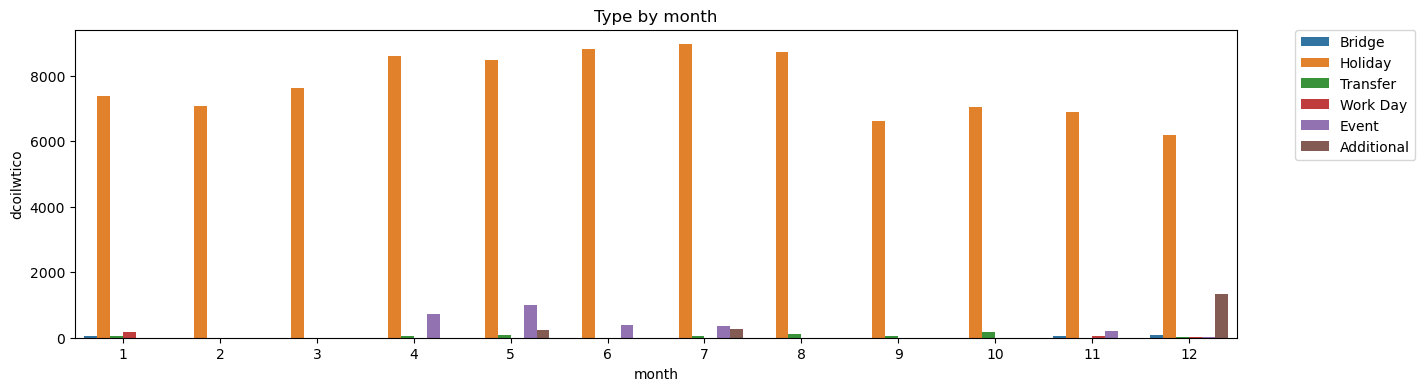

In [41]:
type_by_month_count = df.groupby(['month', 'type'])['dcoilwtico'].sum()
type_by_month_count = type_by_month_count.reset_index()

plt.figure(figsize=(15,4))
sns.barplot(data=type_by_month_count, x=type_by_month_count['month'], y=type_by_month_count['dcoilwtico'], hue=type_by_month_count['type'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Type by month')

In [42]:
types = pd.get_dummies(df['type'])
locale = pd.get_dummies(df['locale'])
locale_name = pd.get_dummies(df['locale_name'])
transferred = pd.get_dummies(df['transferred'], drop_first=True)

df = pd.concat([df, types], axis=1)
df = pd.concat([df, locale], axis=1)
df = pd.concat([df, locale_name], axis=1)
df = pd.concat([df, transferred], axis=1)

df = df.drop(['type', 'locale', 'locale_name', 'description', 'transferred','day'], axis=1)
df.head()

,dcoilwtico,month,year,Additional,Bridge,Event,Holiday,Transfer,Work Day,Local,...,Manta,Puyo,Quevedo,Quito,Riobamba,Salinas,Santa Elena,Santo Domingo,Santo Domingo de los Tsachilas,True
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,54.32,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,93.14,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-03,92.97,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-04,93.12,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-07,93.20,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df[True] = df[True].astype('uint8')
df.columns = df.columns.map(str)

In [44]:
from sklearn.preprocessing import MinMaxScaler
train = df.loc[df.index < '2017-04-23']
test = df.loc[df.index >= '2017-04-23'].drop('dcoilwtico', axis=1)
test_y = df.loc[df.index >= '2017-04-23']['dcoilwtico']


train = pd.DataFrame(train)
train = train.reset_index()
test = test.reset_index()
train = train.rename(columns={'date' : 'ds', 'dcoilwtico' : 'y'})
test_x = test.rename(columns={'date' : 'ds', 'dcoilwtico' : 'y'})

train.to_csv("train.csv", header=False, index=False)
test.to_csv("test.csv", header=False, index=False)

bucket = sagemaker.Session().default_bucket()

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
bucket

'sagemaker-eu-west-2-866647877267'

In [45]:
model = Prophet(holidays_prior_scale=150, changepoint_prior_scale=60,
               yearly_seasonality=True, weekly_seasonality=True,
               daily_seasonality=True, seasonality_mode='multiplicative')

columns = train.columns.drop(['y', 'ds'])
    
for i in columns:
    model.add_regressor(str(i))

model.fit(train)

15:10:10 - cmdstanpy - INFO - Chain [1] start processing
15:10:11 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
forecast_before = model.predict(test_x)

test_y = test_y.reset_index()

forecast_before['true'] = test_y['dcoilwtico']

mae = mean_absolute_error(forecast_before['true'], forecast_before['yhat'])
mape = mean_absolute_percentage_error(forecast_before['true'], forecast_before['yhat'])

print('MAE is ', mae)
print('MAPE is ', mape)

forecast_before[['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']]

MAE is  5.232344468510803
MAPE is  0.11128156093288878


,ds,yhat,true,yhat_lower,yhat_upper
0,2017-04-24,51.933490,48.90,40.545083,63.925330
1,2017-04-25,52.700411,49.22,40.093436,63.672781
2,2017-04-26,52.900951,49.22,41.322084,64.199650
3,2017-04-27,52.894032,48.96,41.499855,64.084423
4,2017-04-28,52.835313,49.31,41.528468,64.219427
...,...,...,...,...,...
131,2017-12-22,37.817496,32.70,-56.480272,142.139449
132,2017-12-23,34.427529,32.70,-53.601537,131.490438
133,2017-12-24,34.645217,32.70,-56.393589,133.910125
134,2017-12-25,45.349939,32.70,-77.862946,175.472598


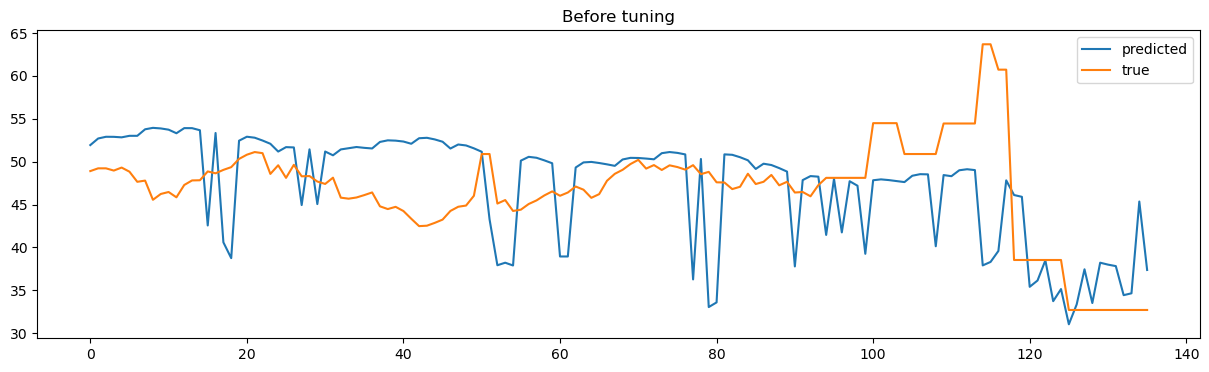

In [47]:
plt.figure(figsize=(15,4))
plt.plot(forecast_before['yhat'], label='predicted')
plt.plot(forecast_before['true'], label='true')
plt.legend()
plt.title('Before tuning')
plt.show()

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [300],
    'seasonality_prior_scale': [60],
    'yearly_seasonality' : [1,2,3],
    'weekly_seasonality' : [1,2,3],
    'daily_seasonality' : [1,2,3],
    'seasonality_mode' : ['multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    for i in columns:
        m.add_regressor(str(i))
    m.fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='1482 days', period='50 days', horizon = '10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])
    print(df_p['mape'].values[0])
    clear_output(wait=True)


# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale  yearly_seasonality  \
0                       300                       60                   1   
1                       300                       60                   1   
2                       300                       60                   1   
3                       300                       60                   1   
4                       300                       60                   1   
5                       300                       60                   1   
6                       300                       60                   1   
7                       300                       60                   1   
8                       300                       60                   1   
9                       300                       60                   2   
10                      300                       60                   2   
11                      300                       60                   2   
12          

In [60]:
best_params = all_params[np.argmin(mape)]
print(min(tuning_results['mape']))
print(best_params)

0.11754555996340695
{'changepoint_prior_scale': 300, 'seasonality_prior_scale': 60, 'yearly_seasonality': 3, 'weekly_seasonality': 1, 'daily_seasonality': 3, 'seasonality_mode': 'multiplicative'}


In [64]:
model = Prophet(changepoint_prior_scale=300,
                seasonality_prior_scale=60,
                yearly_seasonality=3,
                weekly_seasonality=1,
                daily_seasonality=3,
                seasonality_mode='multiplicative')

for i in columns:
    model.add_regressor(str(i))
    
model.fit(train)

15:47:38 - cmdstanpy - INFO - Chain [1] start processing
15:47:39 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
forecast = model.predict(test_x)
#test_y = test_y.reset_index()
forecast['true'] = test_y['dcoilwtico']

forecast[['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']]

,ds,yhat,true,yhat_lower,yhat_upper
0,2017-04-24,51.351466,48.90,38.816961,62.780892
1,2017-04-25,52.184575,49.22,40.447193,64.114359
2,2017-04-26,52.604327,49.22,40.620719,65.007290
3,2017-04-27,52.290035,48.96,39.275125,64.542994
4,2017-04-28,51.474161,49.31,39.543886,63.841601
...,...,...,...,...,...
131,2017-12-22,37.295261,32.70,-85.822323,168.350199
132,2017-12-23,36.707842,32.70,-82.296125,162.071132
133,2017-12-24,36.709802,32.70,-82.820647,163.670098
134,2017-12-25,47.477048,32.70,-114.858640,218.396038


In [66]:
mape = mean_absolute_percentage_error(forecast['true'], forecast['yhat'])
mae = mean_absolute_error(forecast['true'], forecast['yhat'])

print('MAPE is ', round(mape, 3))
print('MAE is ', round(mae,3))
#test_y = test_y.reset_index()
forecast['true'] = test_y['dcoilwtico']

forecast [['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']].head()

MAPE is  0.107
MAE is  4.998


,ds,yhat,true,yhat_lower,yhat_upper
0,2017-04-24,51.351466,48.90,38.816961,62.780892
1,2017-04-25,52.184575,49.22,40.447193,64.114359
2,2017-04-26,52.604327,49.22,40.620719,65.007290
3,2017-04-27,52.290035,48.96,39.275125,64.542994
4,2017-04-28,51.474161,49.31,39.543886,63.841601


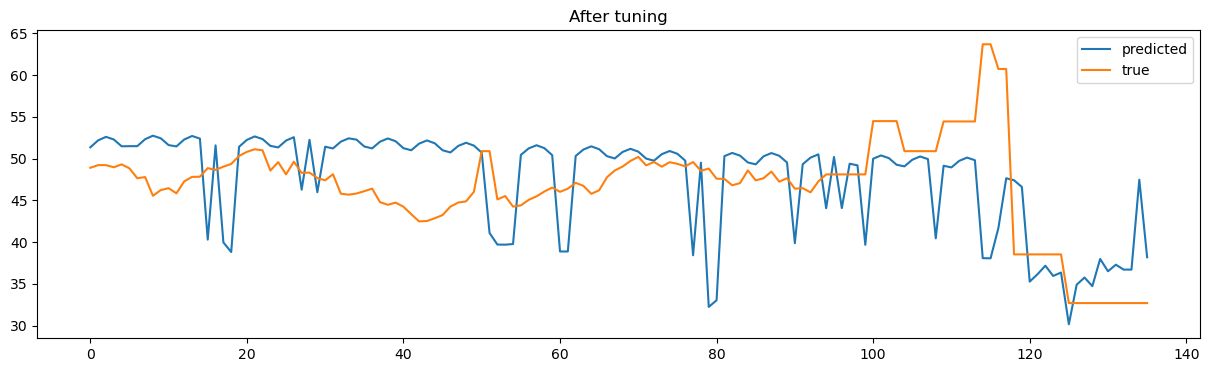

In [67]:
plt.figure(figsize=(15,4))
plt.plot(forecast['yhat'], label='predicted')
plt.plot(forecast['true'], label='true')
plt.legend()
plt.title('After tuning')
plt.show()